# AquaYOLO model for Underwater Object Detection

This is a replication of the model/architecture purposed in **AquaYOLO: Enhancing YOLOv8 for Accurate Underwater Object Detection for Sonar Images**. The paper can be found at [this link](https://www.mdpi.com/2077-1312/13/1/73). 

# Dataset Setup


## Getting the data (if not already done)
Using the UATD dataset:

- Download the dataset from [here](hhttps://figshare.com/articles/dataset/UATD_Dataset/21331143/3). Download all 4 zips.
- Create ./data folder within the model. (Like this: ./aqua_yolo/data)
- Place the downloaded .zip files inside the data-folder
- Then unzip them manually or running code below:

In [33]:
import zipfile
import os

zip_paths = [ "data/UATD_Test_1.zip", "data/UATD_Test_2.zip", "data/UATD_Training.zip",]
extract_dir = "data/UATD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(zip_path, " extracted to:", os.path.abspath(extract_dir))

data/UATD_Test_1.zip  extracted to: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD
data/UATD_Test_2.zip  extracted to: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD
data/UATD_Training.zip  extracted to: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD


## Setup on YOLO format

### Set up the paths

In [7]:
# Set up the paths

from pathlib import Path

ROOT = Path.cwd()
DATA = ROOT / "data" / "UATD"

UATD_TRAIN = DATA / "UATD_Training"
UATD_VAL   = DATA / "UATD_Test_1"
UATD_TEST  = DATA / "UATD_Test_2"

# YOLO folders directly inside UATD/
YOLO_IMG = DATA / "images"
YOLO_LBL = DATA / "labels"

# Create standard YOLO directory tree
for split in ["train", "val", "test"]:
    (YOLO_IMG / split).mkdir(parents=True, exist_ok=True)
    (YOLO_LBL / split).mkdir(parents=True, exist_ok=True)

print("✅ YOLO structure ready at:", DATA)


✅ YOLO structure ready at: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD


### Convert from XMLs -> YOLO format

In [40]:
# Convert XMLs → YOLO labels

import glob, shutil
from xml.etree import ElementTree as ET

SPLIT_MAP = {
    "train": UATD_TRAIN,
    "val":   UATD_VAL,
    "test":  UATD_TEST,
}

def parse_box(obj):
    bb = obj.find("bndbox")
    return (
        float(bb.findtext("xmin")),
        float(bb.findtext("ymin")),
        float(bb.findtext("xmax")),
        float(bb.findtext("ymax")),
    )

def voc_to_yolo(xmin, ymin, xmax, ymax, w, h):
    cx = ((xmin + xmax) / 2) / w
    cy = ((ymin + ymax) / 2) / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return cx, cy, bw, bh

def sanitize(name: str):
    return name.strip().replace(" ", "-").lower()

def convert_to_yolo():
    class_to_id, classes = {}, []

    for split, src_dir in SPLIT_MAP.items():
        ann_dir = src_dir / "annotations"
        img_dir = src_dir / "images"
        xmls = sorted(glob.glob(str(ann_dir / "*.xml")))
        print(f"[{split}] Found {len(xmls)} XMLs")

        for xml in xmls:
            root = ET.parse(xml).getroot()
            w = int(root.find("size").findtext("width"))
            h = int(root.find("size").findtext("height"))
            fname = root.find("file").findtext("filename") or Path(xml).stem
            stem = Path(fname).stem
            img_src = img_dir / f"{stem}.bmp"

            if not img_src.exists():
                print(f"⚠️ Missing image for {stem}.bmp")
                continue

            # Write YOLO label
            lbl_path = YOLO_LBL / split / f"{stem}.txt"
            with open(lbl_path, "w") as y:
                for obj in root.findall("object"):
                    cname = sanitize(obj.findtext("name"))
                    if cname not in class_to_id:
                        class_to_id[cname] = len(classes)
                        classes.append(cname)
                    cls_id = class_to_id[cname]
                    xmin, ymin, xmax, ymax = parse_box(obj)
                    cx, cy, bw, bh = voc_to_yolo(xmin, ymin, xmax, ymax, w, h)
                    y.write(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

            # Copy image to YOLO folder
            dst_img = YOLO_IMG / split / img_src.name
            if not dst_img.exists():
                shutil.copy2(img_src, dst_img)

    print("✅ Conversion complete.")
    print("Classes:", classes)
    return classes

CLASSES = convert_to_yolo()


[train] Found 7600 XMLs
[val] Found 800 XMLs
[test] Found 800 XMLs
✅ Conversion complete.
Classes: ['human-body', 'ball', 'circle-cage', 'square-cage', 'tyre', 'metal-bucket', 'cube', 'cylinder', 'plane', 'rov']


## Labels validation


### Check validity

Here we check if the BB and classes are valid.

In [1]:
# check if valid:
#!/usr/bin/env python3
# check_yolo_annotations.py
#
# Validate YOLO labels under data/UATD/{images,labels}/{train,val,test}.
# Reports missing pairs and per-line label errors.

from pathlib import Path
import glob

DATA_ROOT = Path("data/UATD")
SPLITS = ["train", "val", "test"]
NUM_CLASSES = 10
EPS = 1e-9

def list_stems(dirpath: Path, pattern: str):
    return {Path(p).stem for p in glob.glob(str(dirpath / pattern))}

def validate_line(parts, split, stem, lineno):
    """Return None if ok, else an error string."""
    if len(parts) < 5:
        return f"[{split}] {stem}.txt:{lineno}: expected 5 values 'cls cx cy w h', got {len(parts)}"

    # parse values
    try:
        cls = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:5])
    except Exception as e:
        return f"[{split}] {stem}.txt:{lineno}: parse error: {e}"

    # class check
    if not (0 <= cls < NUM_CLASSES):
        return f"[{split}] {stem}.txt:{lineno}: class {cls} not in [0..{NUM_CLASSES-1}]"

    # bounds checks (YOLO normalized)
    if not (0.0 <= cx <= 1.0) or not (0.0 <= cy <= 1.0):
        return f"[{split}] {stem}.txt:{lineno}: center out of range (cx={cx:.6f}, cy={cy:.6f})"

    # width/height correspond to (xmax-xmin)/W and (ymax-ymin)/H
    if not (w > EPS and h > EPS):
        return f"[{split}] {stem}.txt:{lineno}: non-positive box size (w={w:.6f}, h={h:.6f})"
    if w > 1.0 or h > 1.0:
        return f"[{split}] {stem}.txt:{lineno}: box size exceeds 1.0 (w={w:.6f}, h={h:.6f})"

    return None

def main():
    total_invalid = 0
    total_missing_img = 0
    total_missing_lbl = 0

    for split in SPLITS:
        img_dir = DATA_ROOT / "images" / split
        lbl_dir = DATA_ROOT / "labels" / split

        # basic presence
        if not img_dir.exists() or not lbl_dir.exists():
            print(f"[{split}] missing folder(s): images={img_dir.exists()} labels={lbl_dir.exists()}")
            continue

        imgs = list_stems(img_dir, "*.*")
        lbls = list_stems(lbl_dir, "*.txt")

        # pair checks
        miss_img = sorted(lbls - imgs)
        miss_lbl = sorted(imgs - lbls)

        for s in miss_img:
            print(f"[{split}] missing image for label: {s}.txt → expected in {img_dir}")
        for s in miss_lbl:
            print(f"[{split}] missing label for image: {s}.* → expected {lbl_dir}/{s}.txt")

        total_missing_img += len(miss_img)
        total_missing_lbl += len(miss_lbl)

        # label content checks
        invalid = 0
        for stem in sorted(lbls & imgs):  # only those that have both
            path = lbl_dir / f"{stem}.txt"
            try:
                with open(path, "r") as f:
                    for i, line in enumerate(f, 1):
                        line = line.strip()
                        if not line:
                            # empty lines are invalid for YOLO format
                            print(f"[{split}] {stem}.txt:{i}: empty line")
                            invalid += 1
                            continue
                        parts = line.split()
                        err = validate_line(parts, split, stem, i)
                        if err:
                            print(err)
                            invalid += 1
            except Exception as e:
                print(f"[{split}] {stem}.txt: unable to read: {e}")
                invalid += 1

        total_invalid += invalid
        print(f"[{split}] summary → invalid lines: {invalid}, missing images: {len(miss_img)}, missing labels: {len(miss_lbl)}")

    print("-" * 60)
    print(f"TOTAL invalid lines: {total_invalid}")
    print(f"TOTAL missing images for labels: {total_missing_img}")
    print(f"TOTAL missing labels for images: {total_missing_lbl}")

if __name__ == "__main__":
    main()


[train] 00402.txt:1: non-positive box size (w=0.000000, h=-0.000974)
[train] 00438.txt:2: non-positive box size (w=-0.001953, h=0.000000)
[train] 00707.txt:2: non-positive box size (w=-0.001953, h=0.000000)
[train] 02477.txt:1: non-positive box size (w=0.000000, h=0.001629)
[train] 02589.txt:1: non-positive box size (w=0.013672, h=0.000000)
[train] 02630.txt:3: non-positive box size (w=0.000000, h=0.001342)
[train] 03412.txt:1: non-positive box size (w=0.220703, h=-0.012418)
[train] 06644.txt:1: center out of range (cx=1.268555, cy=0.867735)
[train] 06719.txt:1: non-positive box size (w=0.066406, h=-0.001087)
[train] 06975.txt:1: non-positive box size (w=0.000000, h=-0.000973)
[train] 07583.txt:1: non-positive box size (w=-0.005859, h=-0.000815)
[train] summary → invalid lines: 11, missing images: 0, missing labels: 0
[val] 00247.txt:1: non-positive box size (w=0.000000, h=0.000000)
[val] 00614.txt:2: non-positive box size (w=0.000000, h=0.000000)
[val] summary → invalid lines: 2, miss

### (Optinal) Remove invalid images

The dataset seems to have some invalid instances as seen above. These images are removed entirely from the dataset. This is optional.

In [4]:
#!/usr/bin/env python3
# cleanup_invalid_yolo.py
#
# Removes any image + label pair that fails basic YOLO validity checks.
# - Deletes files with invalid label lines (bad class, bad coords, empty lines)
# - Deletes orphan images or orphan labels
# - Prints a full summary of removed files

from pathlib import Path
import glob
import os

DATA_ROOT = Path("data/UATD")
SPLITS = ["train", "val", "test"]
NUM_CLASSES = 10
EPS = 1e-9


def list_stems(dirpath: Path, pattern: str):
    return {Path(p).stem for p in glob.glob(str(dirpath / pattern))}


def label_has_error(lbl_path: Path):
    """Return True if label has any invalid lines."""
    try:
        with open(lbl_path, "r") as f:
            lines = [l.strip() for l in f if l.strip()]
        if not lines:
            return True
        for i, line in enumerate(lines, 1):
            parts = line.split()
            if len(parts) < 5:
                return True
            try:
                cls = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
            except Exception:
                return True
            if not (0 <= cls < NUM_CLASSES):
                return True
            if not (0 <= cx <= 1 and 0 <= cy <= 1):
                return True
            if not (w > EPS and h > EPS and w <= 1.0 and h <= 1.0):
                return True
    except Exception:
        return True
    return False


def safe_remove(path: Path):
    if path.exists():
        path.unlink()
        print(f"🗑️ Removed {path}")


def main():
    total_removed = 0
    for split in SPLITS:
        img_dir = DATA_ROOT / "images" / split
        lbl_dir = DATA_ROOT / "labels" / split
        if not img_dir.exists() or not lbl_dir.exists():
            print(f"[{split}] missing images/labels folder — skipping")
            continue

        imgs = list_stems(img_dir, "*.*")
        lbls = list_stems(lbl_dir, "*.txt")

        # Orphan labels (no image)
        for s in sorted(lbls - imgs):
            lbl_path = lbl_dir / f"{s}.txt"
            safe_remove(lbl_path)
            total_removed += 1

        # Orphan images (no label)
        for s in sorted(imgs - lbls):
            for ext in [".bmp", ".jpg", ".png", ".jpeg"]:
                img_path = img_dir / f"{s}{ext}"
                if img_path.exists():
                    safe_remove(img_path)
                    total_removed += 1
                    break

        # Check each label and remove invalid ones (and its image)
        for s in sorted(lbls & imgs):
            lbl_path = lbl_dir / f"{s}.txt"
            if label_has_error(lbl_path):
                # remove label + all possible image extensions
                safe_remove(lbl_path)
                for ext in [".bmp", ".jpg", ".png", ".jpeg"]:
                    img_path = img_dir / f"{s}{ext}"
                    if img_path.exists():
                        safe_remove(img_path)
                        break
                total_removed += 1

    print("------------------------------------------------")
    print(f"✅ Cleanup complete. Total removed image/label pairs: {total_removed}")


if __name__ == "__main__":
    main()


🗑️ Removed data/UATD/labels/train/00402.txt
🗑️ Removed data/UATD/images/train/00402.bmp
🗑️ Removed data/UATD/labels/train/00438.txt
🗑️ Removed data/UATD/images/train/00438.bmp
🗑️ Removed data/UATD/labels/train/00707.txt
🗑️ Removed data/UATD/images/train/00707.bmp
🗑️ Removed data/UATD/labels/train/02477.txt
🗑️ Removed data/UATD/images/train/02477.bmp
🗑️ Removed data/UATD/labels/train/02589.txt
🗑️ Removed data/UATD/images/train/02589.bmp
🗑️ Removed data/UATD/labels/train/02630.txt
🗑️ Removed data/UATD/images/train/02630.bmp
🗑️ Removed data/UATD/labels/train/03412.txt
🗑️ Removed data/UATD/images/train/03412.bmp
🗑️ Removed data/UATD/labels/train/06644.txt
🗑️ Removed data/UATD/images/train/06644.bmp
🗑️ Removed data/UATD/labels/train/06719.txt
🗑️ Removed data/UATD/images/train/06719.bmp
🗑️ Removed data/UATD/labels/train/06975.txt
🗑️ Removed data/UATD/images/train/06975.bmp
🗑️ Removed data/UATD/labels/train/07583.txt
🗑️ Removed data/UATD/images/train/07583.bmp
🗑️ Removed data/UATD/labels/val/

## Make the config file

In [42]:
from pathlib import Path

ROOT = Path.cwd()
DATA = ROOT / "data" / "UATD"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "val"
IMAGES_TEST  = DATA / "images" / "test"

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}

# UATD has 10 classes
names:
  - human-body
  - ball
  - circle-cage
  - square-cage
  - tyre
  - metal-bucket
  - cube
  - cylinder
  - plane
  - rov
"""

yaml_path = DATA / "uatd.yaml"
yaml_path.write_text(dataset_yaml)
print("✅ Wrote:", yaml_path)



✅ Wrote: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD/uatd.yaml


## Now lets vizualise some data:


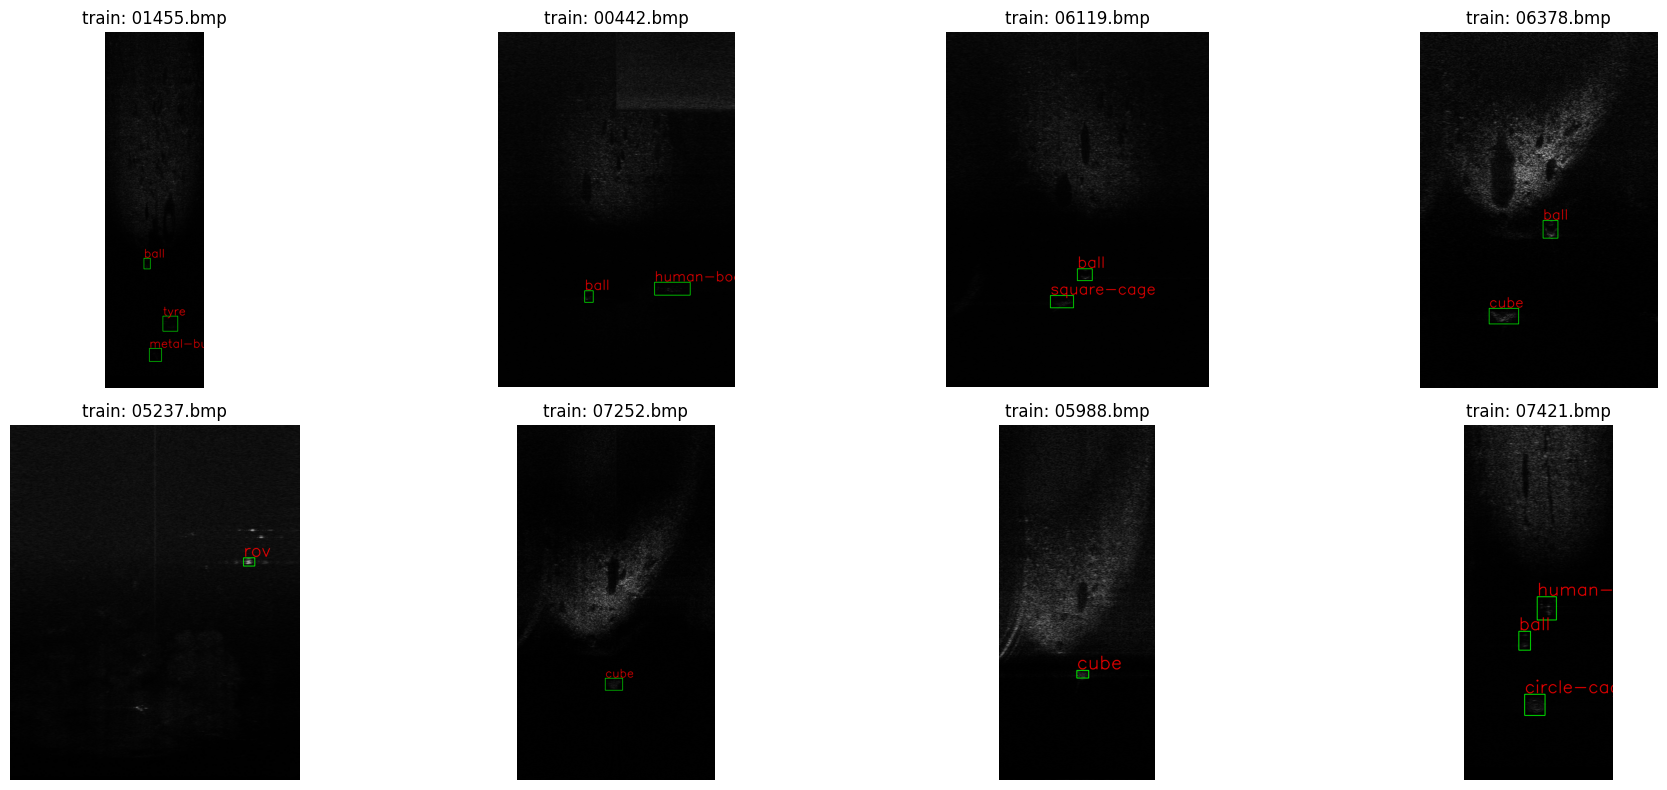

In [9]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import yaml

# ---------------- config ----------------
DATA_ROOT = Path("data/UATD")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train", "val", or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4

# Try to read class names from data/UATD/uatd.yaml; fall back to a default list
NAMES = None
yaml_path = DATA_ROOT / "uatd.yaml"
if yaml_path.exists():
    try:
        y = yaml.safe_load(yaml_path.read_text())
        if isinstance(y.get("names"), list):
            NAMES = y["names"]
        elif isinstance(y.get("names"), dict):
            # sort by numeric key (0..n-1)
            NAMES = [name for _, name in sorted(y["names"].items(), key=lambda kv: int(kv[0]))]
    except Exception as e:
        print("Warning: could not parse names from uatd.yaml:", e)

if not NAMES:
    # Fallback UATD names (lowercase, hyphenated to match our earlier converters)
    NAMES = [
        "cube","ball","cylinder","human-body","plane",
        "circle-cage","square-cage","metal-bucket","tyre","rov"
    ]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)  # green box
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_AA)  # red text
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (prefer ones with labels)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout()
plt.show()


In [10]:
# ============================================================
# Visualize a specific YOLO-annotated image
# ============================================================
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import re
import yaml

# ---------------- Configuration ----------------
DATA_ROOT = Path("data/UATD")
IMG_DIR = DATA_ROOT / "images"
LAB_DIR = DATA_ROOT / "labels"

SPLIT = "train"        # "train", "val", or "test"
IMAGE_NAME = "00402.bmp"   # <-- change this to your file

# Optional: read names from data/UATD/uatd.yaml
yaml_path = DATA_ROOT / "uatd.yaml"
if yaml_path.exists():
    try:
        y = yaml.safe_load(yaml_path.read_text())
        if isinstance(y.get("names"), list):
            NAMES = y["names"]
        elif isinstance(y.get("names"), dict):
            NAMES = [name for _, name in sorted(y["names"].items(), key=lambda kv: int(kv[0]))]
        else:
            NAMES = None
    except Exception:
        NAMES = None
else:
    NAMES = None

# Fallback to default UATD names
if not NAMES:
    NAMES = [
        "human-body", "ball", "circle-cage", "square-cage", "tyre",
        "metal-bucket", "cube", "cylinder", "plane", "rov",
    ]
# ------------------------------------------------


def draw_yolo_labels(image_bgr, label_file: Path, names):
    """Draw YOLO labels (cx, cy, w, h) on the given image."""
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        print(f"⚠️ No label file found: {label_file}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        # Convert normalized YOLO → pixel coordinates
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)

        # Clamp to image bounds
        x1 = max(0, min(w - 1, x1))
        y1 = max(0, min(h - 1, y1))
        x2 = max(0, min(w - 1, x2))
        y2 = max(0, min(h - 1, y2))

        color = (0, 255, 0)  # green box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1 - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)  # red text

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# --- Load image and label ---
img_path = IMG_DIR / SPLIT / IMAGE_NAME
lab_path = LAB_DIR / SPLIT / (Path(IMAGE_NAME).stem + ".txt")

if not img_path.exists():
    raise FileNotFoundError(f"Image not found: {img_path}")

img_bgr = cv2.imread(str(img_path))
if img_bgr is None:
    raise RuntimeError(f"Failed to read image: {img_path}")

# --- Draw and display ---
vis = draw_yolo_labels(img_bgr, lab_path, NAMES)

plt.figure(figsize=(10, 8))
plt.imshow(vis)
plt.title(f"{SPLIT}: {IMAGE_NAME}")
plt.axis("off")
plt.tight_layout()
plt.show()


FileNotFoundError: Image not found: data/UATD/images/train/00402.bmp

## Dataset summary

In [11]:
#!/usr/bin/env python3
# summarize_yolo_dataset.py
#
# Prints a clean summary of a YOLO dataset under data/UATD/{images,labels}/{train,val,test}.
# Shows images & instances per split, per-class counts, and a validity flag.

from pathlib import Path
import glob

# ----- CONFIG -----
DATA_ROOT = Path("data/UATD")
SPLITS = ["train", "val", "test"]
UATD_CLASSES = [
    "human-body", "ball", "circle-cage", "square-cage", "tyre",
    "metal-bucket", "cube", "cylinder", "plane", "rov",
]
NUM_CLASSES = len(UATD_CLASSES)
EPS = 1e-9
# ------------------

def list_stems(dirpath: Path, pattern: str):
    return {Path(p).stem for p in glob.glob(str(dirpath / pattern))}

def validate_line(parts):
    """Return None if ok, else a reason string."""
    if len(parts) < 5:
        return f"expected 5 values 'cls cx cy w h', got {len(parts)}"
    try:
        cls = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:5])
    except Exception as e:
        return f"parse error: {e}"
    if not (0 <= cls < NUM_CLASSES):
        return f"class {cls} not in [0..{NUM_CLASSES-1}]"
    if not (0.0 <= cx <= 1.0 and 0.0 <= cy <= 1.0):
        return f"center out of range (cx={cx:.6f}, cy={cy:.6f})"
    if not (w > EPS and h > EPS and w <= 1.0 and h <= 1.0):
        return f"invalid box size (w={w:.6f}, h={h:.6f})"
    return None

def summarize_split(split: str):
    img_dir = DATA_ROOT / "images" / split
    lbl_dir = DATA_ROOT / "labels" / split
    imgs = list_stems(img_dir, "*.*") if img_dir.exists() else set()
    lbls = list_stems(lbl_dir, "*.txt") if lbl_dir.exists() else set()

    # base validity: pairing
    missing_images = sorted(lbls - imgs)
    missing_labels = sorted(imgs - lbls)

    per_class = [0] * NUM_CLASSES
    instances = 0
    invalid_lines = 0

    # Only iterate over samples that have both image and label
    for stem in sorted(lbls & imgs):
        path = lbl_dir / f"{stem}.txt"
        try:
            with open(path, "r") as f:
                for i, raw in enumerate(f, 1):
                    line = raw.strip()
                    if not line:
                        invalid_lines += 1
                        continue
                    parts = line.split()
                    err = validate_line(parts)
                    if err:
                        invalid_lines += 1
                        continue
                    cls = int(float(parts[0]))
                    per_class[cls] += 1
                    instances += 1
        except Exception:
            invalid_lines += 1

    images_with_labels = len(lbls & imgs)
    everything_valid = (len(missing_images) == 0 and len(missing_labels) == 0 and invalid_lines == 0)

    return {
        "split": split,
        "images_total": len(imgs),
        "labels_total": len(lbls),
        "images_with_labels": images_with_labels,
        "instances": instances,
        "per_class": per_class,
        "missing_images": len(missing_images),
        "missing_labels": len(missing_labels),
        "invalid_lines": invalid_lines,
        "valid": everything_valid,
    }

def print_summary(results):
    # Header
    print("\n=== UATD YOLO Dataset Summary ===\n")

    grand_images = grand_instances = 0
    grand_valid = True
    agg_per_class = [0] * NUM_CLASSES

    # Split summaries
    for r in results:
        grand_images += r["images_total"]
        grand_instances += r["instances"]
        grand_valid = grand_valid and r["valid"]
        agg_per_class = [a + b for a, b in zip(agg_per_class, r["per_class"])]

        print(f"[{r['split']}]")
        print(f"  Images (total):         {r['images_total']}")
        print(f"  Images (with labels):   {r['images_with_labels']}")
        print(f"  Labels (files):         {r['labels_total']}")
        print(f"  Instances:              {r['instances']}")
        print(f"  Valid:                  {'YES' if r['valid'] else 'NO'}"
              f"  (invalid_lines={r['invalid_lines']}, missing_imgs={r['missing_images']}, missing_lbls={r['missing_labels']})")

        # Per-class table
        width = max(len(c) for c in UATD_CLASSES)
        print("  Per-class instances:")
        for i, c in enumerate(UATD_CLASSES):
            print(f"    {i:2d}  {c.ljust(width)} : {r['per_class'][i]}")
        print("")

    # Totals
    print("=== Totals ===")
    print(f"  Images (total across splits): {grand_images}")
    print(f"  Instances (total):            {grand_instances}")
    print("  Per-class totals:")
    width = max(len(c) for c in UATD_CLASSES)
    for i, c in enumerate(UATD_CLASSES):
        print(f"    {i:2d}  {c.ljust(width)} : {agg_per_class[i]}")
    print(f"\nEverything valid across splits: {'YES' if grand_valid else 'NO'}\n")

def main():
    results = [summarize_split(s) for s in SPLITS]
    print_summary(results)

if __name__ == "__main__":
    main()



=== UATD YOLO Dataset Summary ===

[train]
  Images (total):         7589
  Images (with labels):   7589
  Labels (files):         7589
  Instances:              12287
  Valid:                  YES  (invalid_lines=0, missing_imgs=0, missing_lbls=0)
  Per-class instances:
     0  human-body   : 1281
     1  ball         : 3067
     2  circle-cage  : 660
     3  square-cage  : 979
     4  tyre         : 1123
     5  metal-bucket : 475
     6  cube         : 2643
     7  cylinder     : 564
     8  plane        : 795
     9  rov          : 700

[val]
  Images (total):         798
  Images (with labels):   798
  Labels (files):         798
  Instances:              1169
  Valid:                  YES  (invalid_lines=0, missing_imgs=0, missing_lbls=0)
  Per-class instances:
     0  human-body   : 76
     1  ball         : 197
     2  circle-cage  : 98
     3  square-cage  : 167
     4  tyre         : 121
     5  metal-bucket : 6
     6  cube         : 172
     7  cylinder     : 48
     8  pl

# Building

Building (and training) of the model happens in [train.py](./train.py). The model is constructed by the [aquayolo.yaml](./models/aquayolo.yaml), that imports modules from custom blocks (see paragraph below).


### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../ultralytics/ultralytics/nn/modules/block.py) (classes: AquaResidualBlock, DSAM), [tasks.py](../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



### Is it an accurate replication??

Yes should be pretty good now. Make a detailed description of why **TODO**

# Training

- To train the model run the train.py script by doing: `python3 train.py`

### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 4 GPUS, any. 32 CPU cores, 64 GB RAM, 

- Loaded the pretrained yolov8s to make training faster. 

# Evaluation

### Get results
Here we get the actual results. Files are saved in runs_uwyolo folder.

In [2]:
from ultralytics import YOLO
model = YOLO("runs_aquayolo/aquayolo_m_SGD_640_4gpu_stable2/weights/best.pt")
results = model.val(
    data="data/UATD/uatd.yaml",
    imgsz=640,
    batch=1,
    iou=0.7,
    plots=True,
    project="runs_aquayolo",
    name="aquayolo_eval",
    exist_ok=True
)
print(results)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA A100-PCIE-40GB, 40441MiB)
aquaYOLO summary: 331 layers, 119,756,606 parameters, 0 gradients, 340.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3684.1±499.8 MB/s, size: 4205.5 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD/labels/val.cache... 800 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 800/800 925.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 800/800 45.7it/s 17.5s<0.1s
                   all        800       1172      0.879       0.84      0.829      0.392
            human-body         76         76      0.853      0.868      0.838       0.39
                  ball        197        197      0.834      0.878      0.839      0.447
           circle-cage         99         99       0.72      0.424      0.471      0.228
           square-cage        167        167       0.86      0.625      0.681  

### Show images in Notebook
This is for showing stuff in the notebook. The images are saved in the eval folder (these are not on git)

📈 BoxPR_curve.png


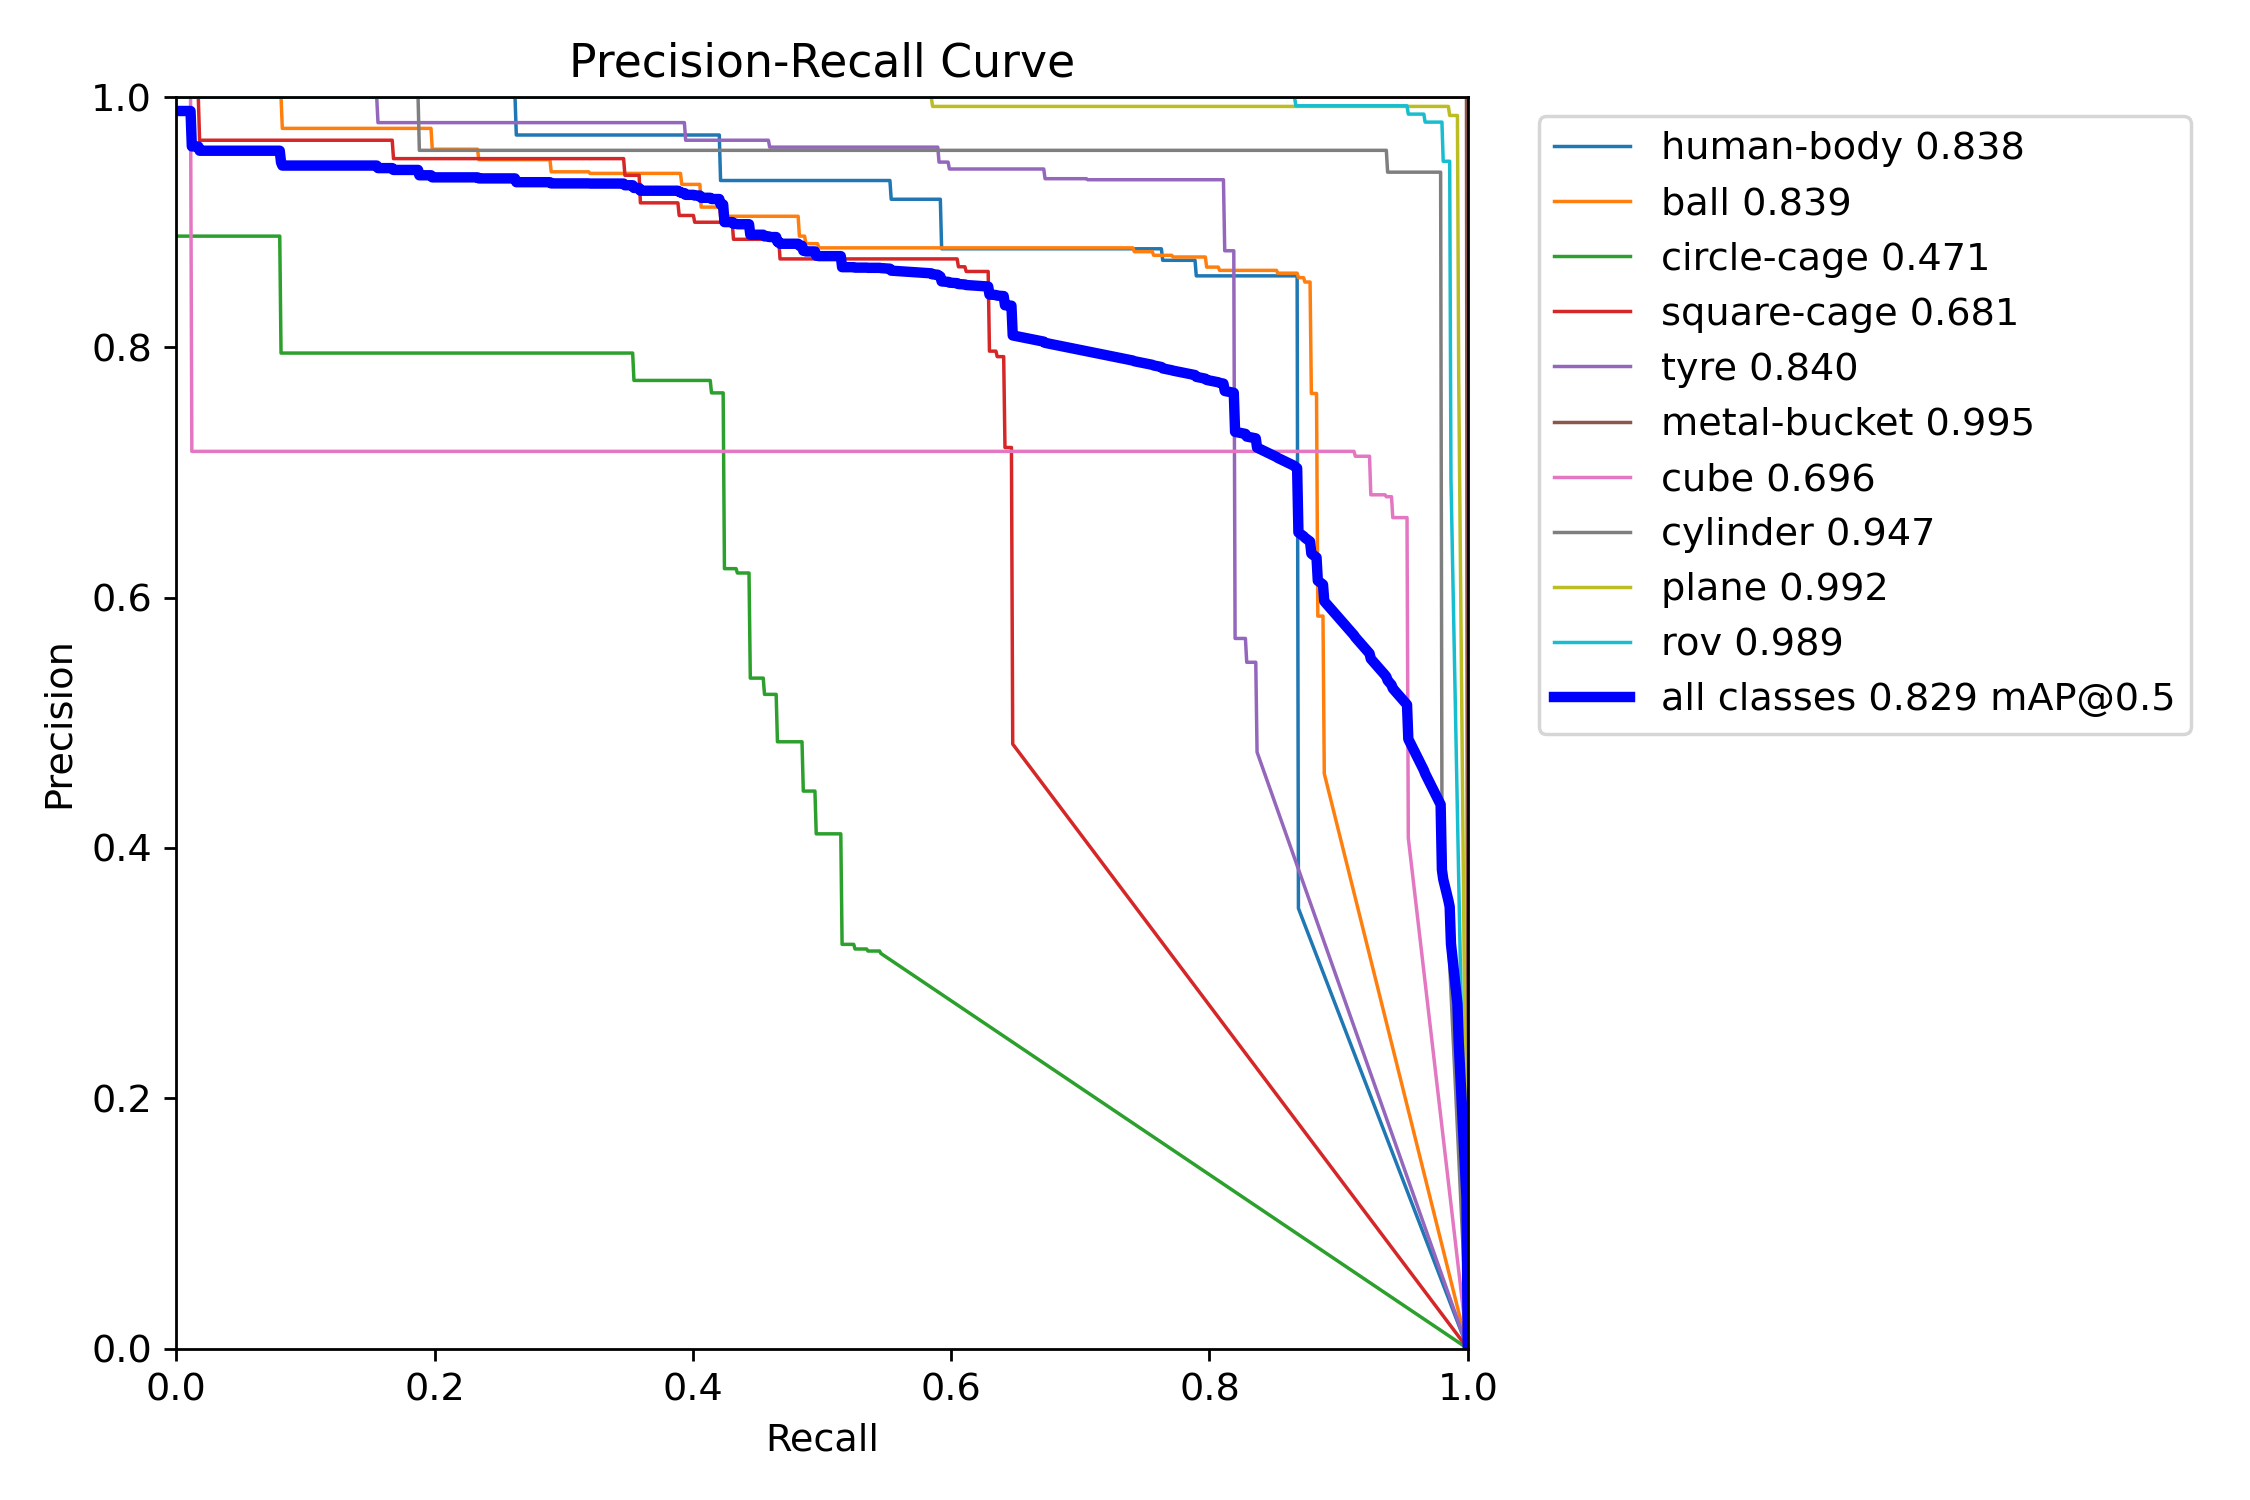

📈 BoxP_curve.png


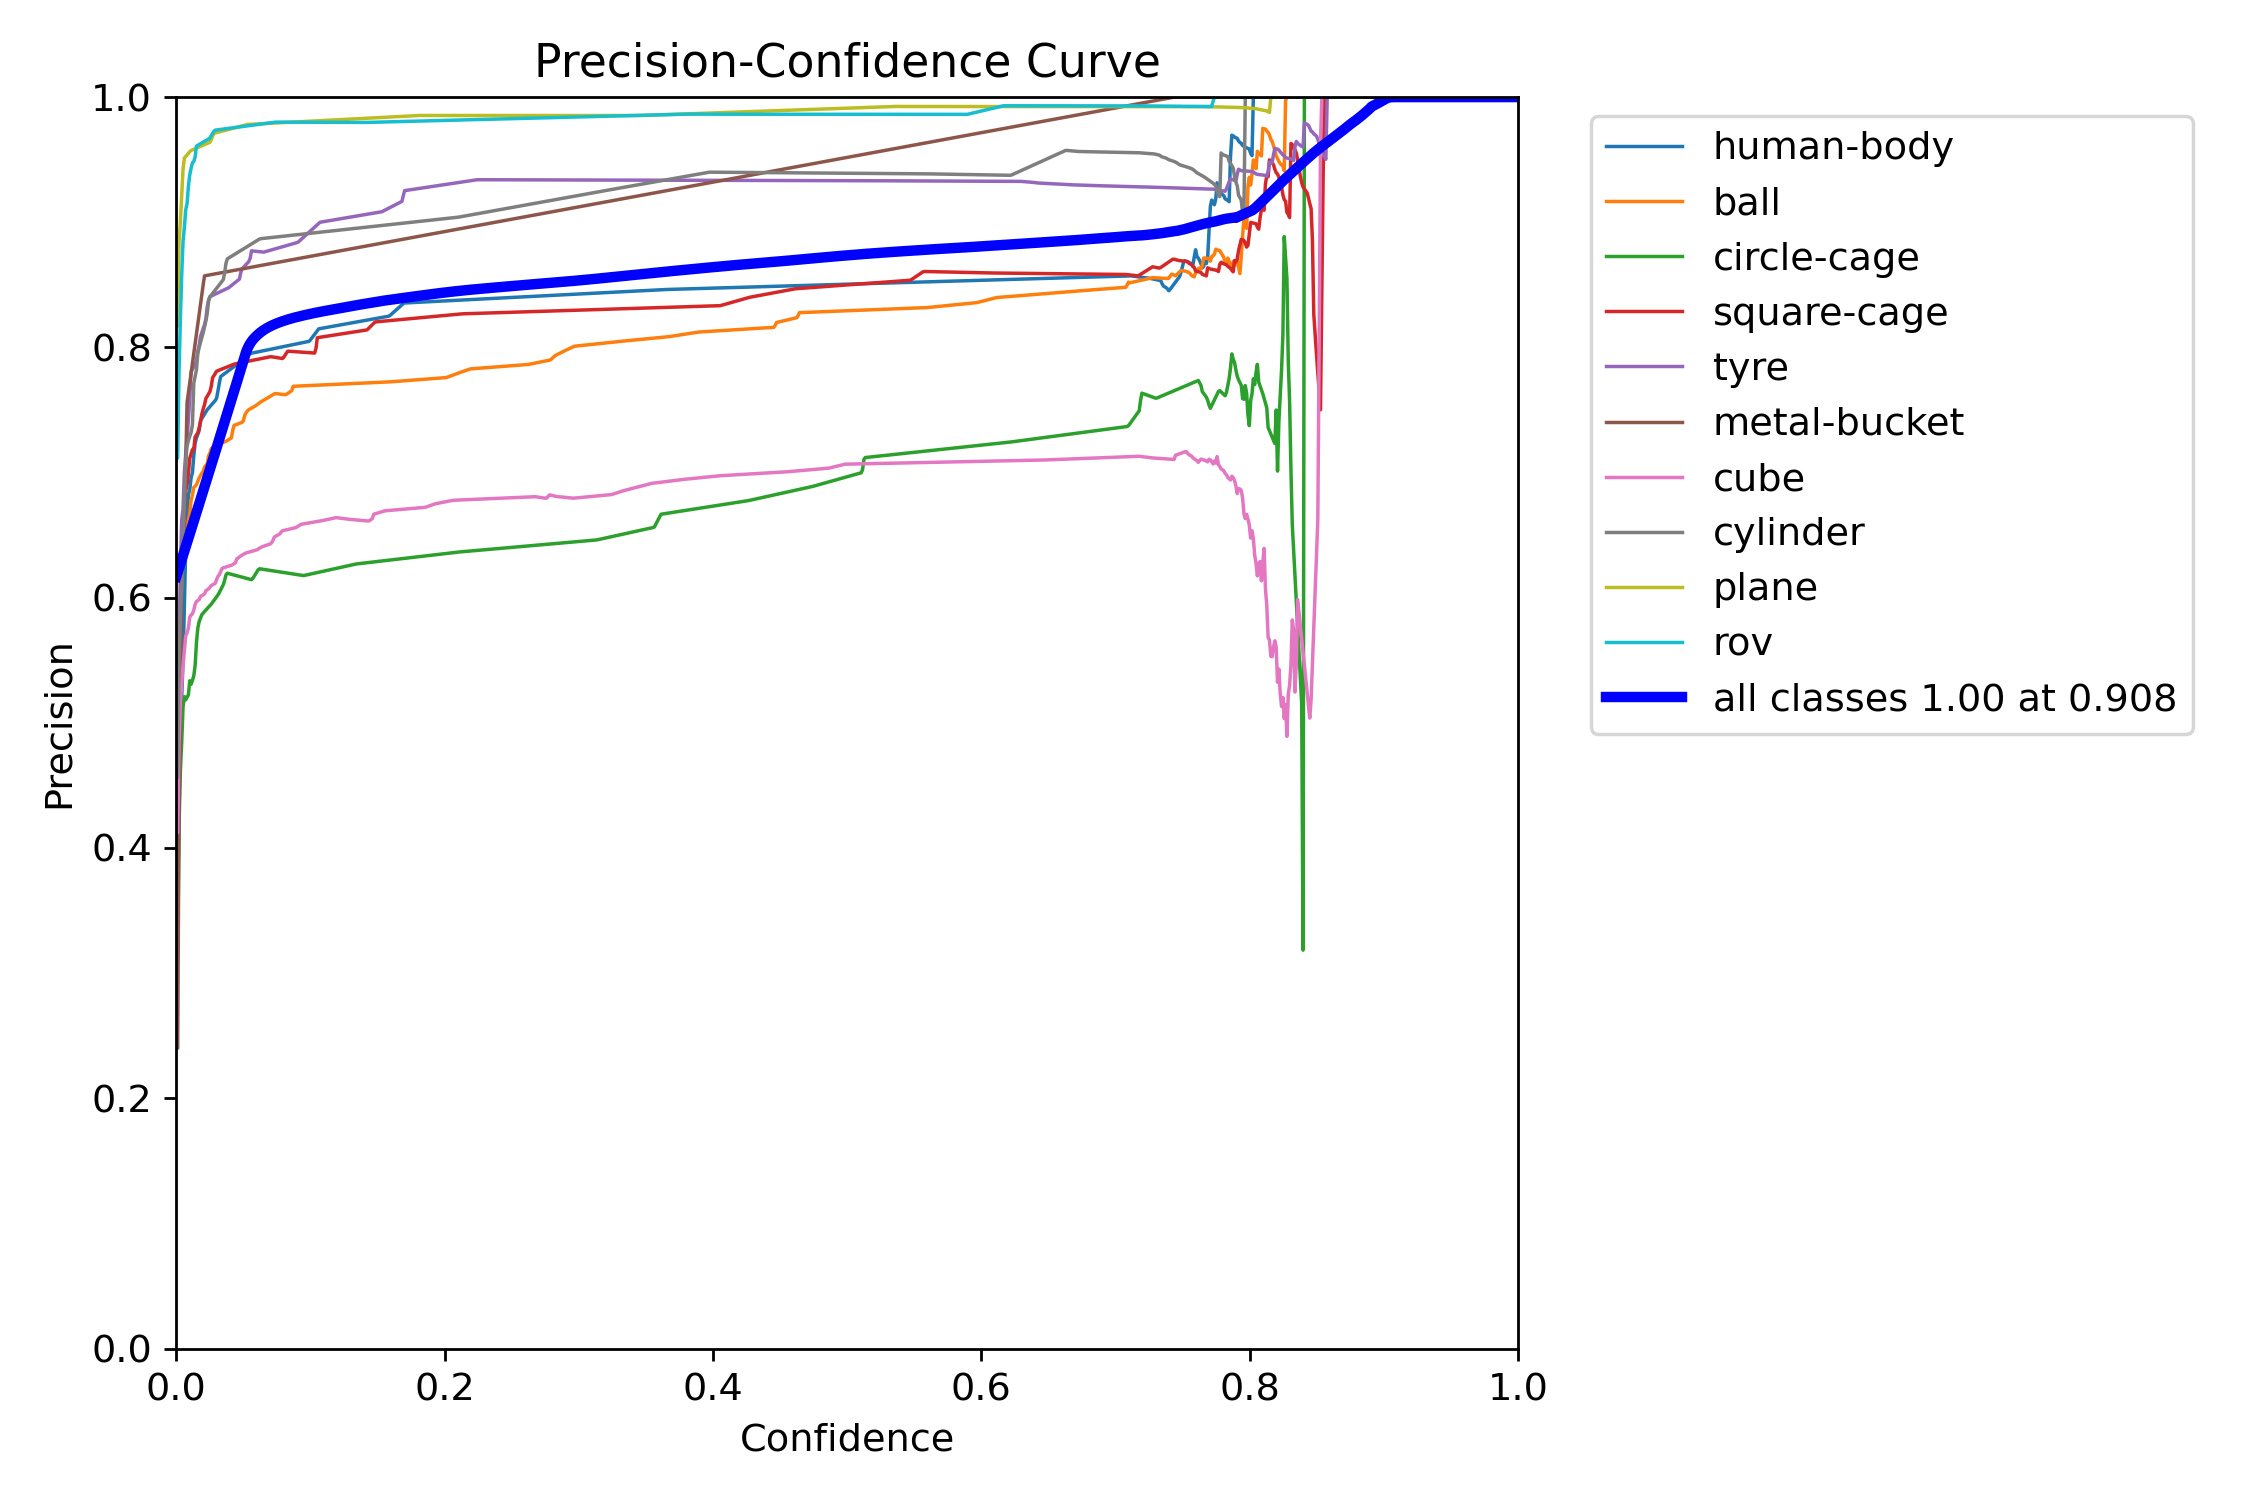

📈 BoxR_curve.png


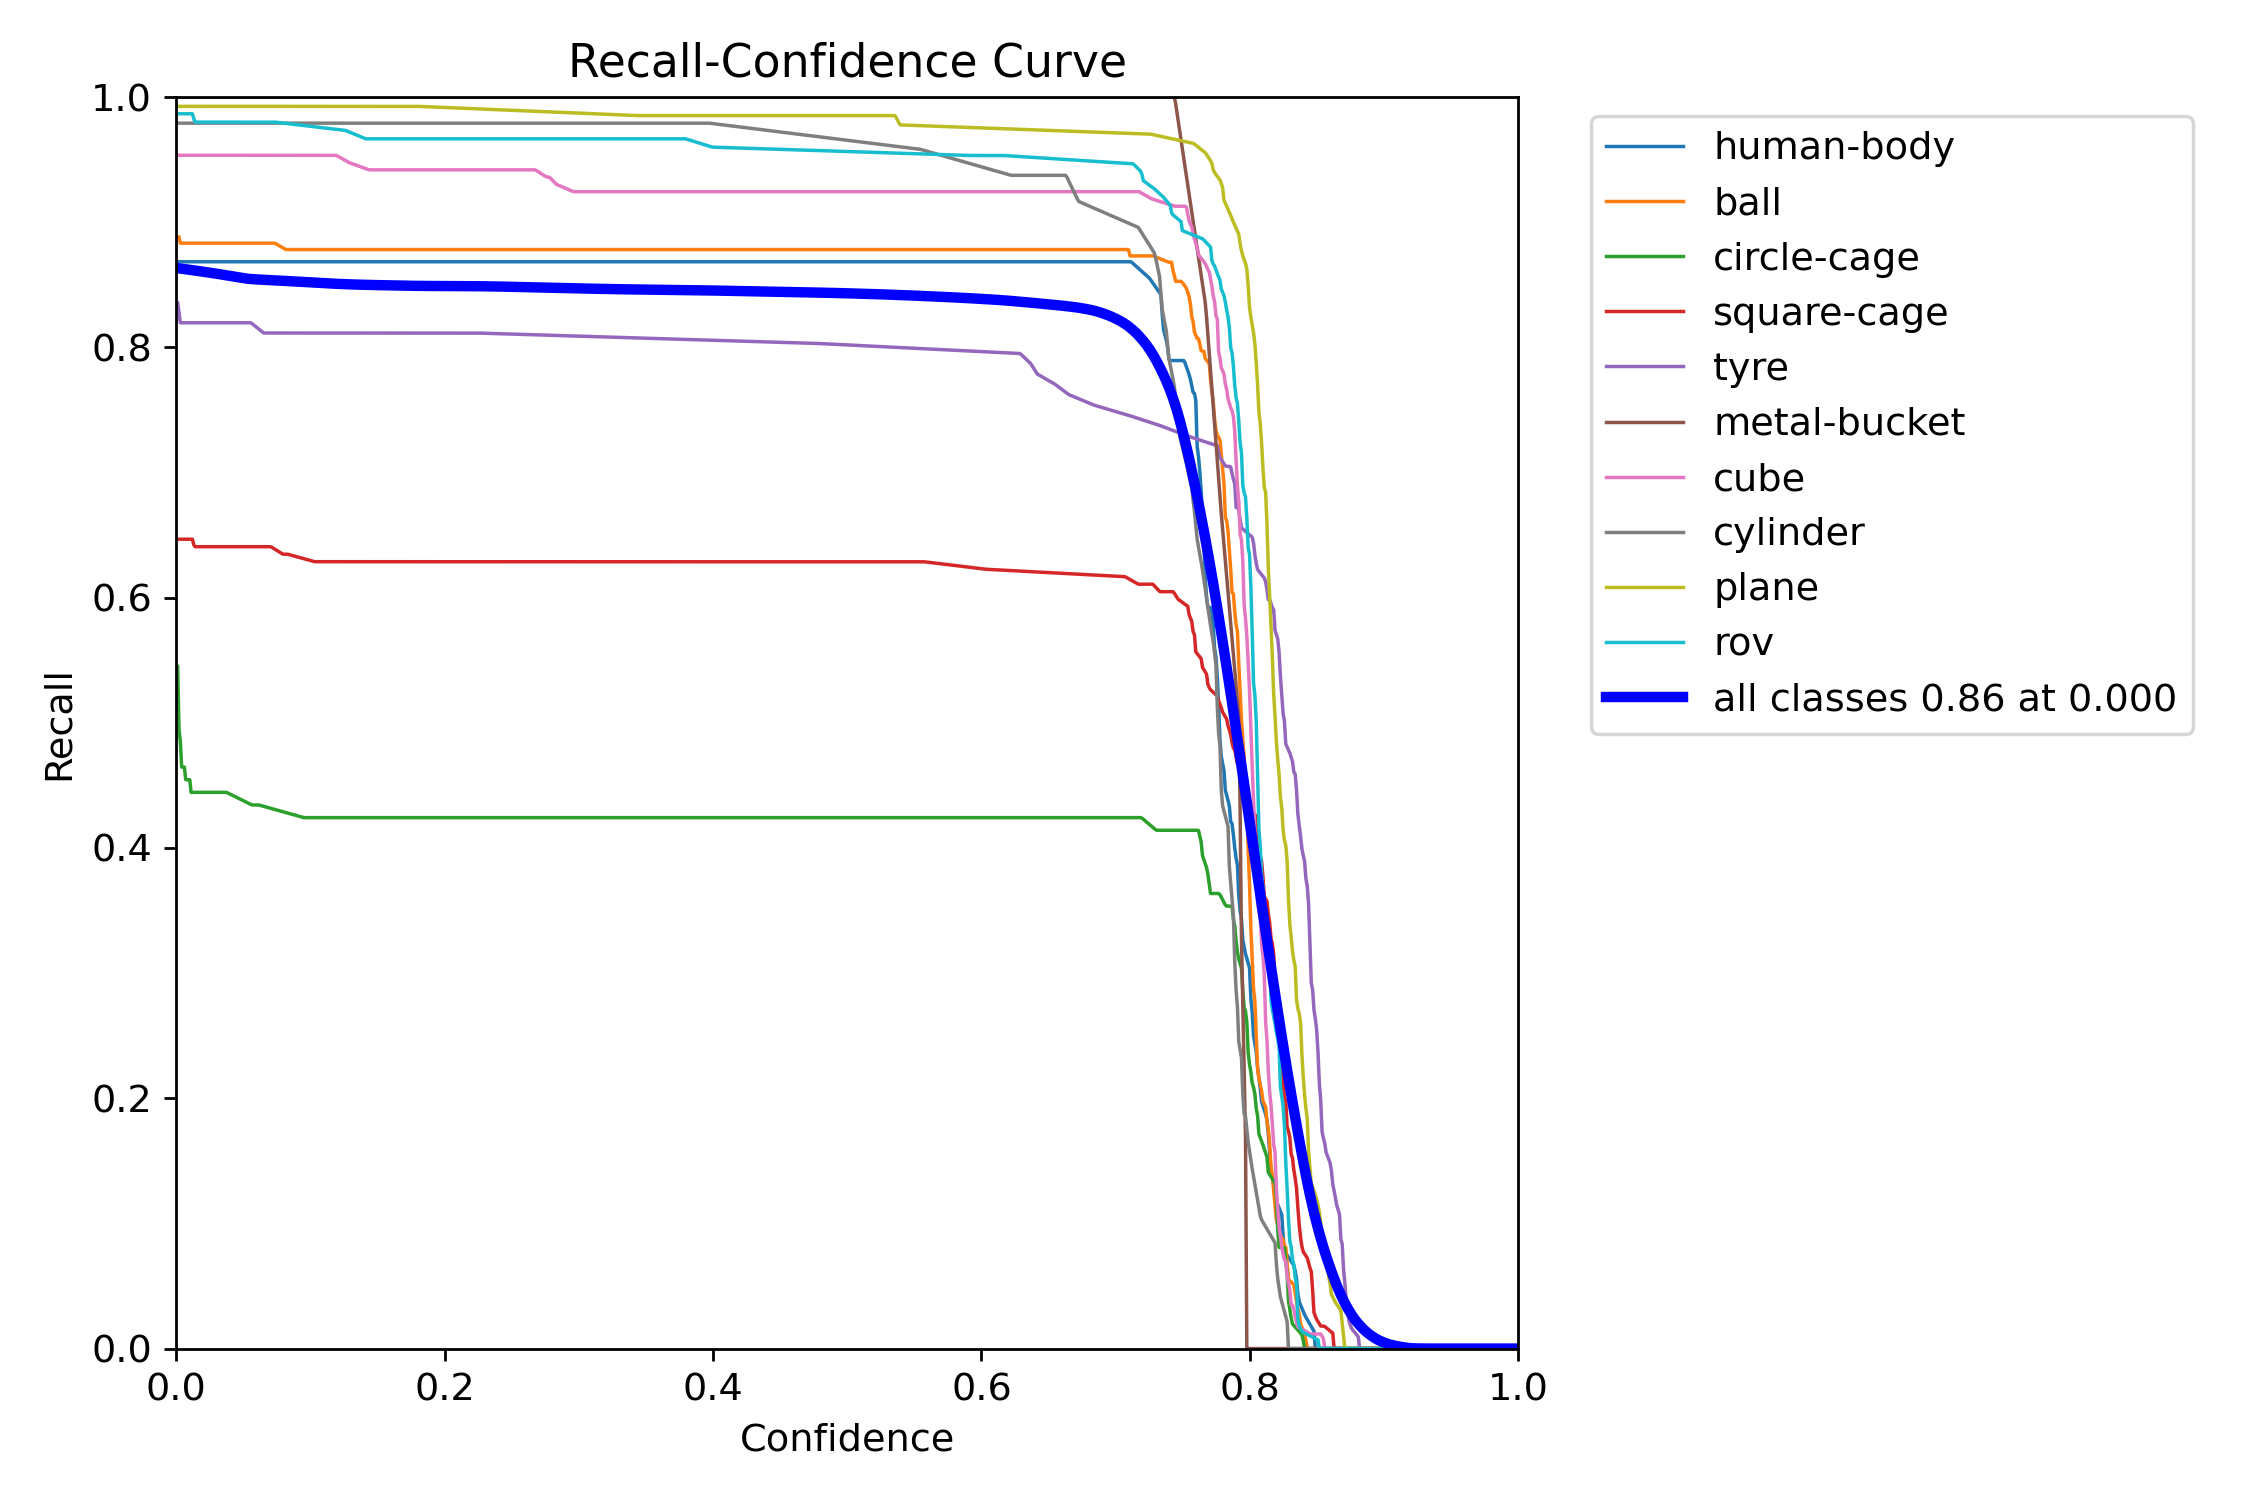

📈 BoxF1_curve.png


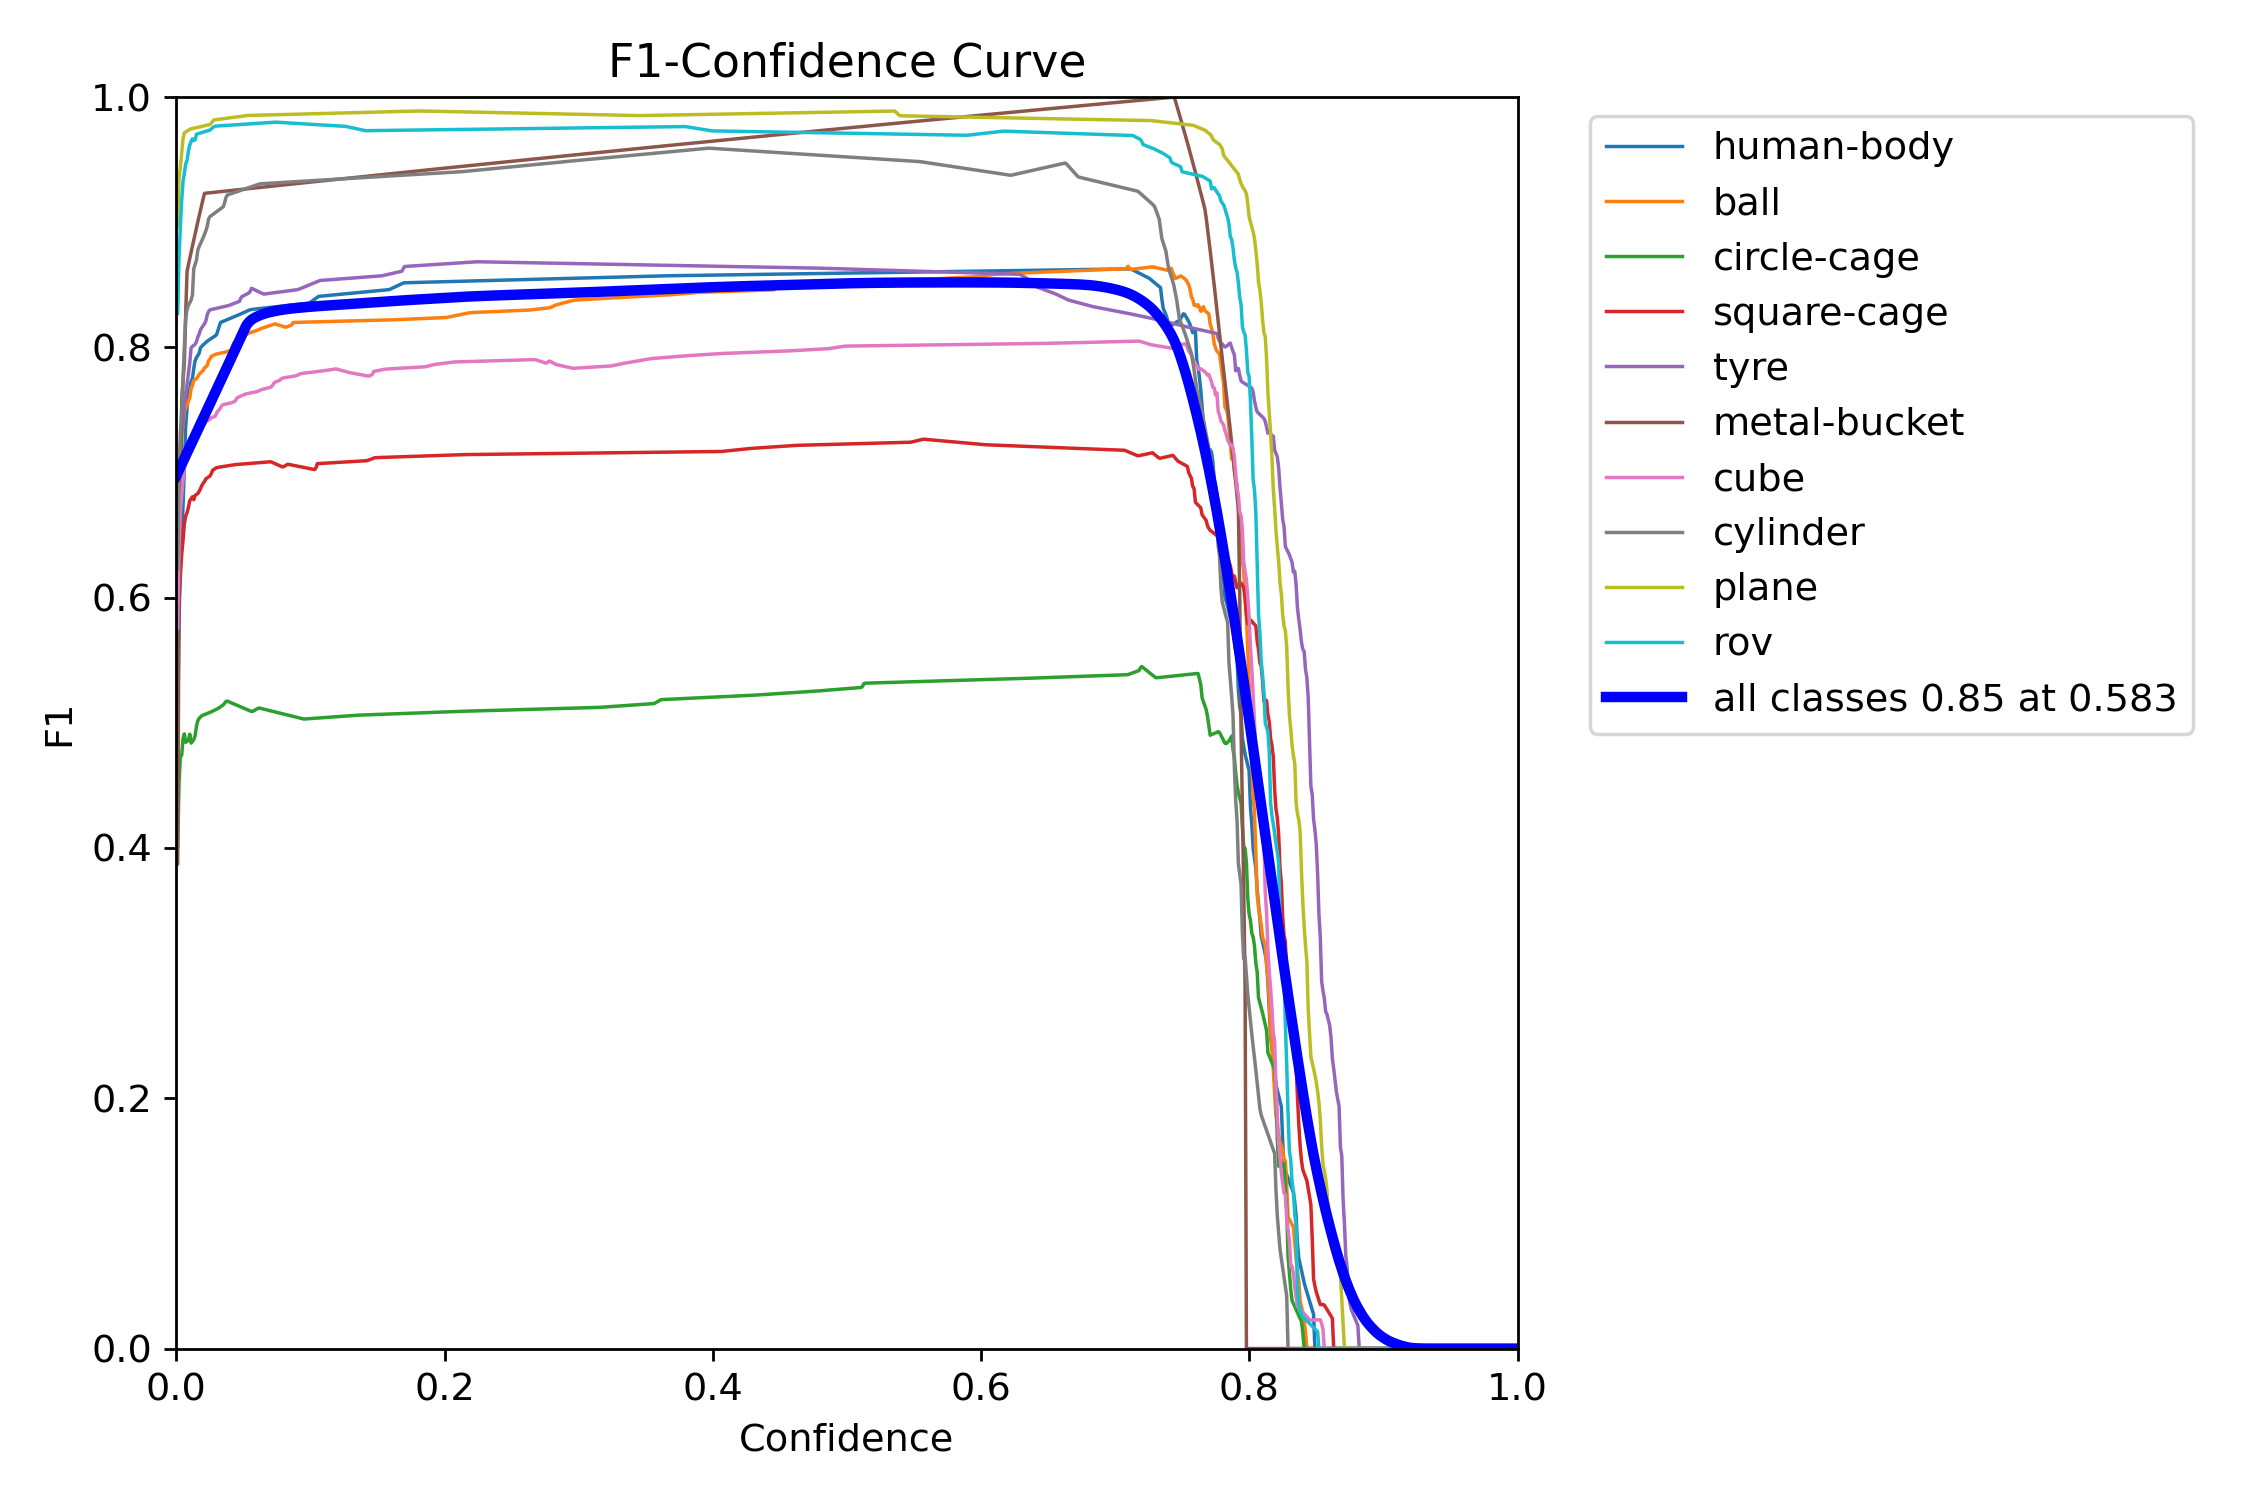

📈 confusion_matrix.png


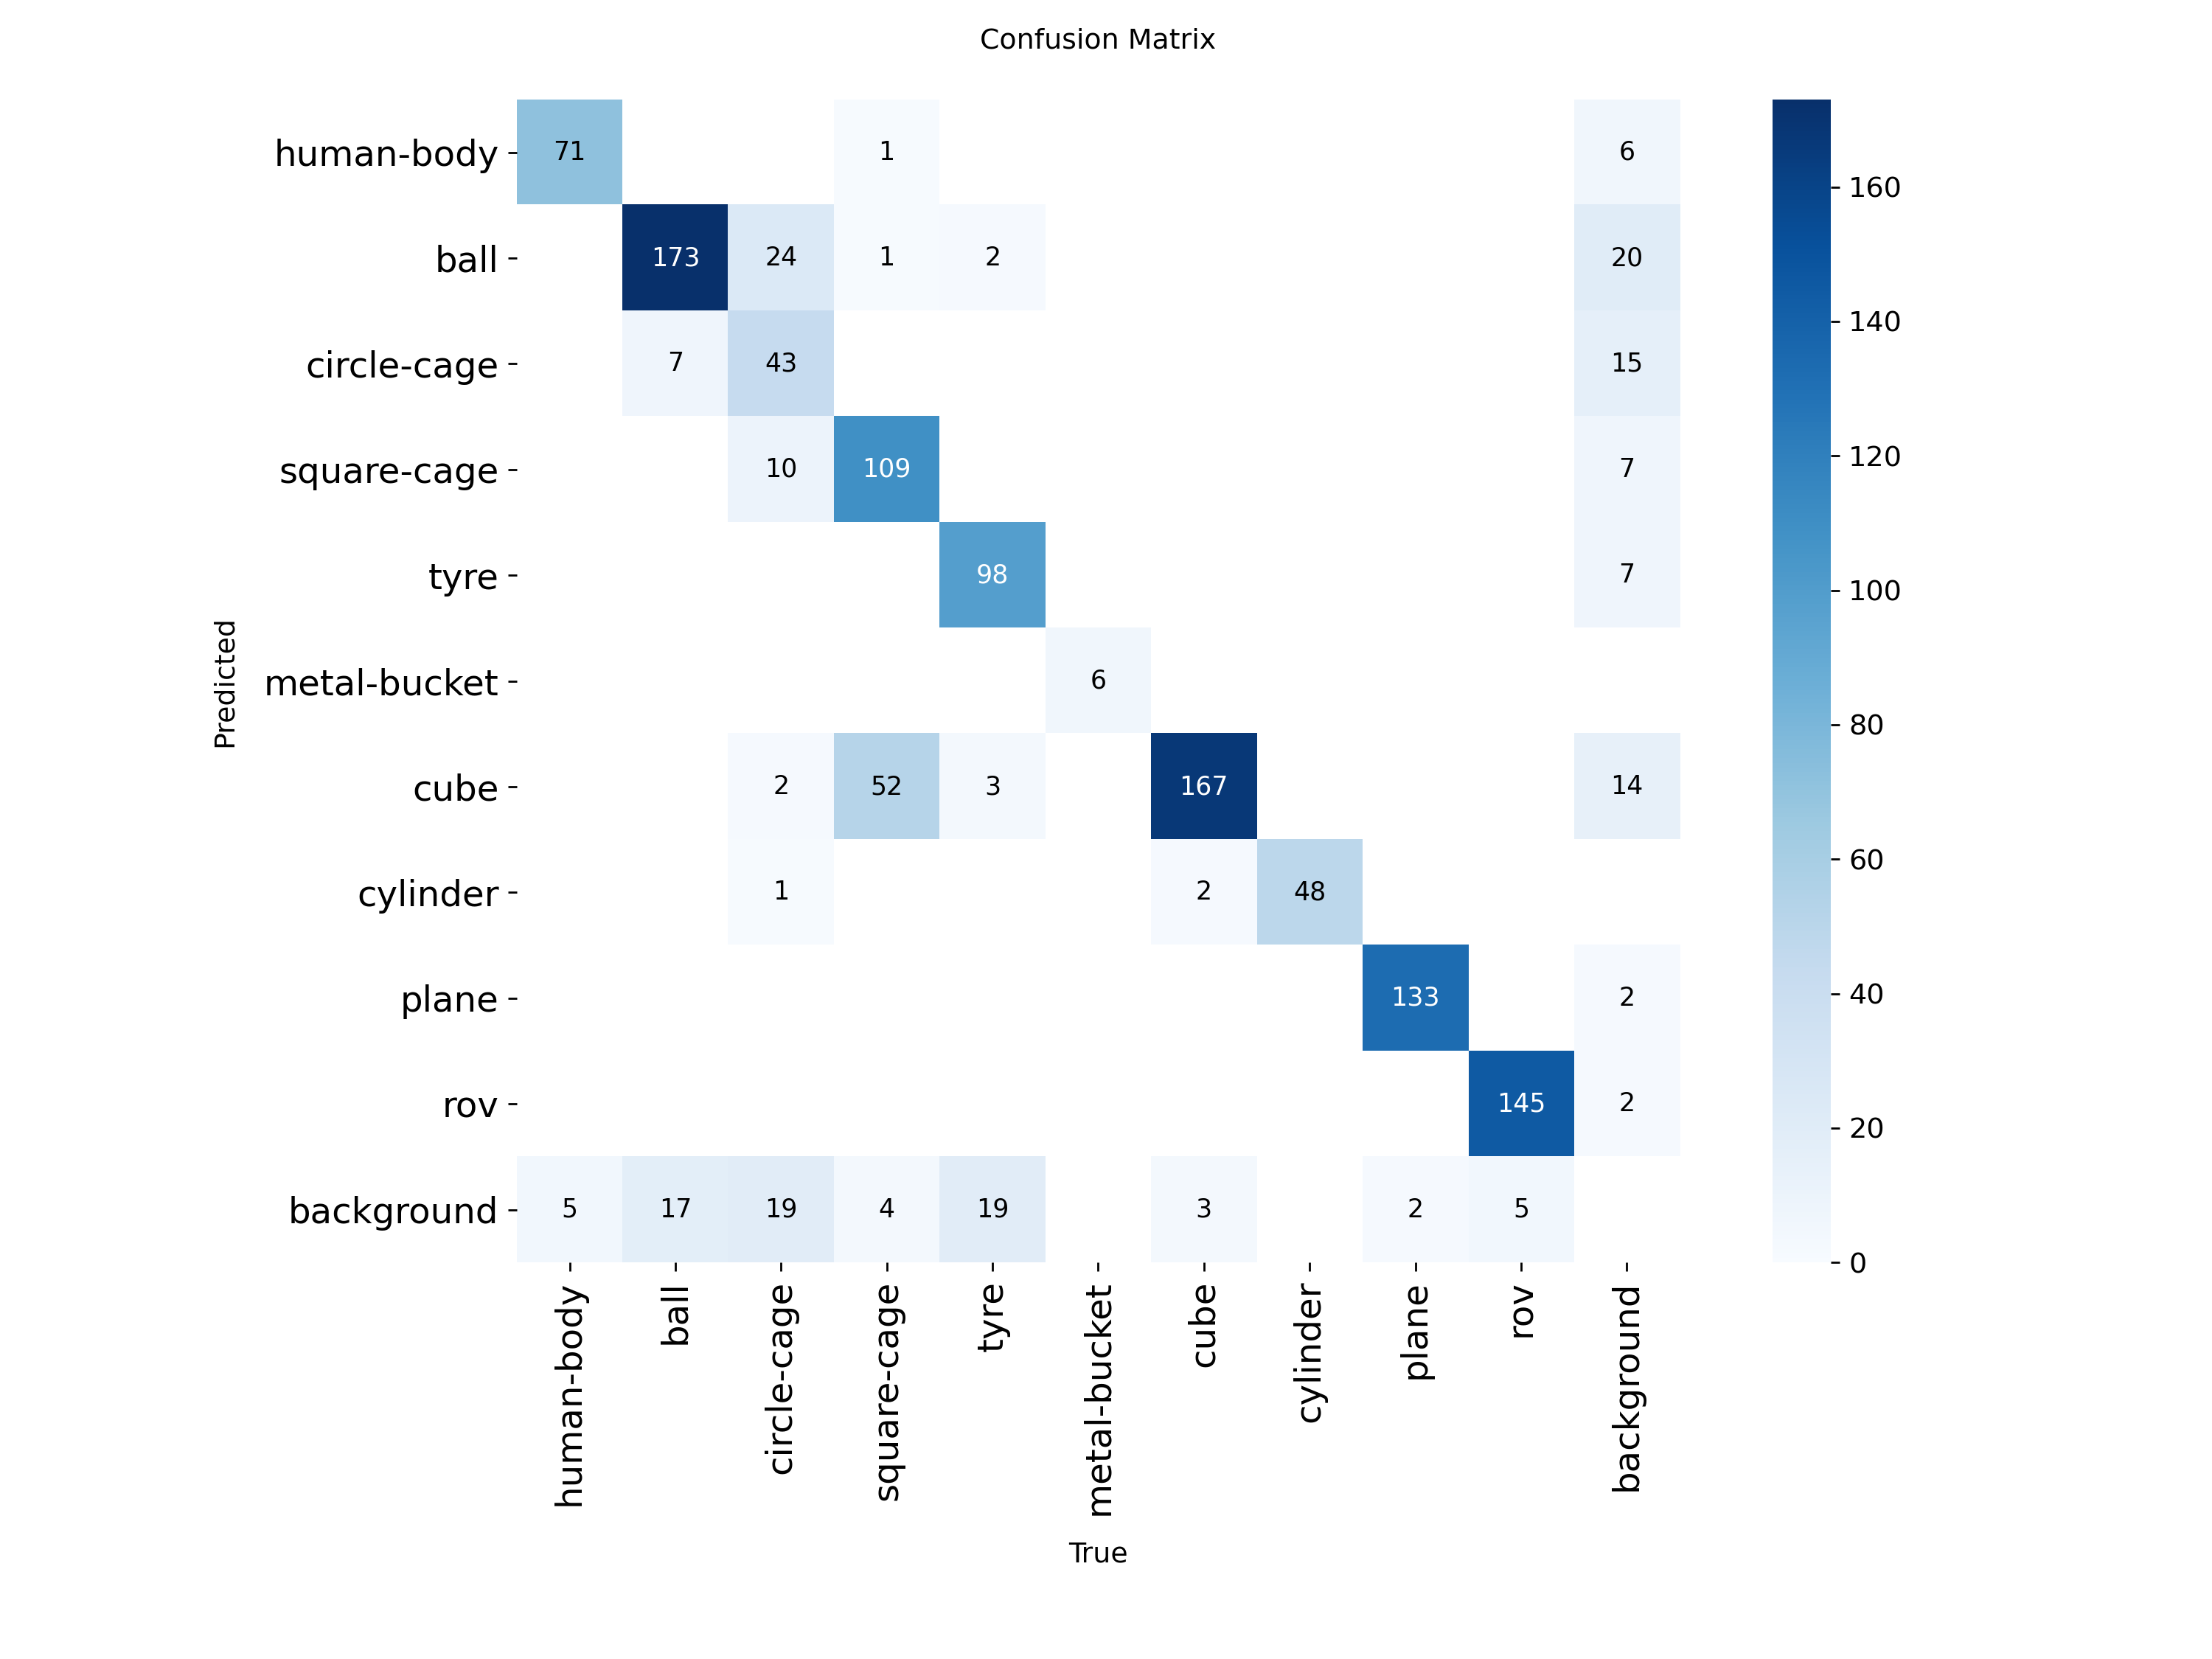

📈 confusion_matrix_normalized.png


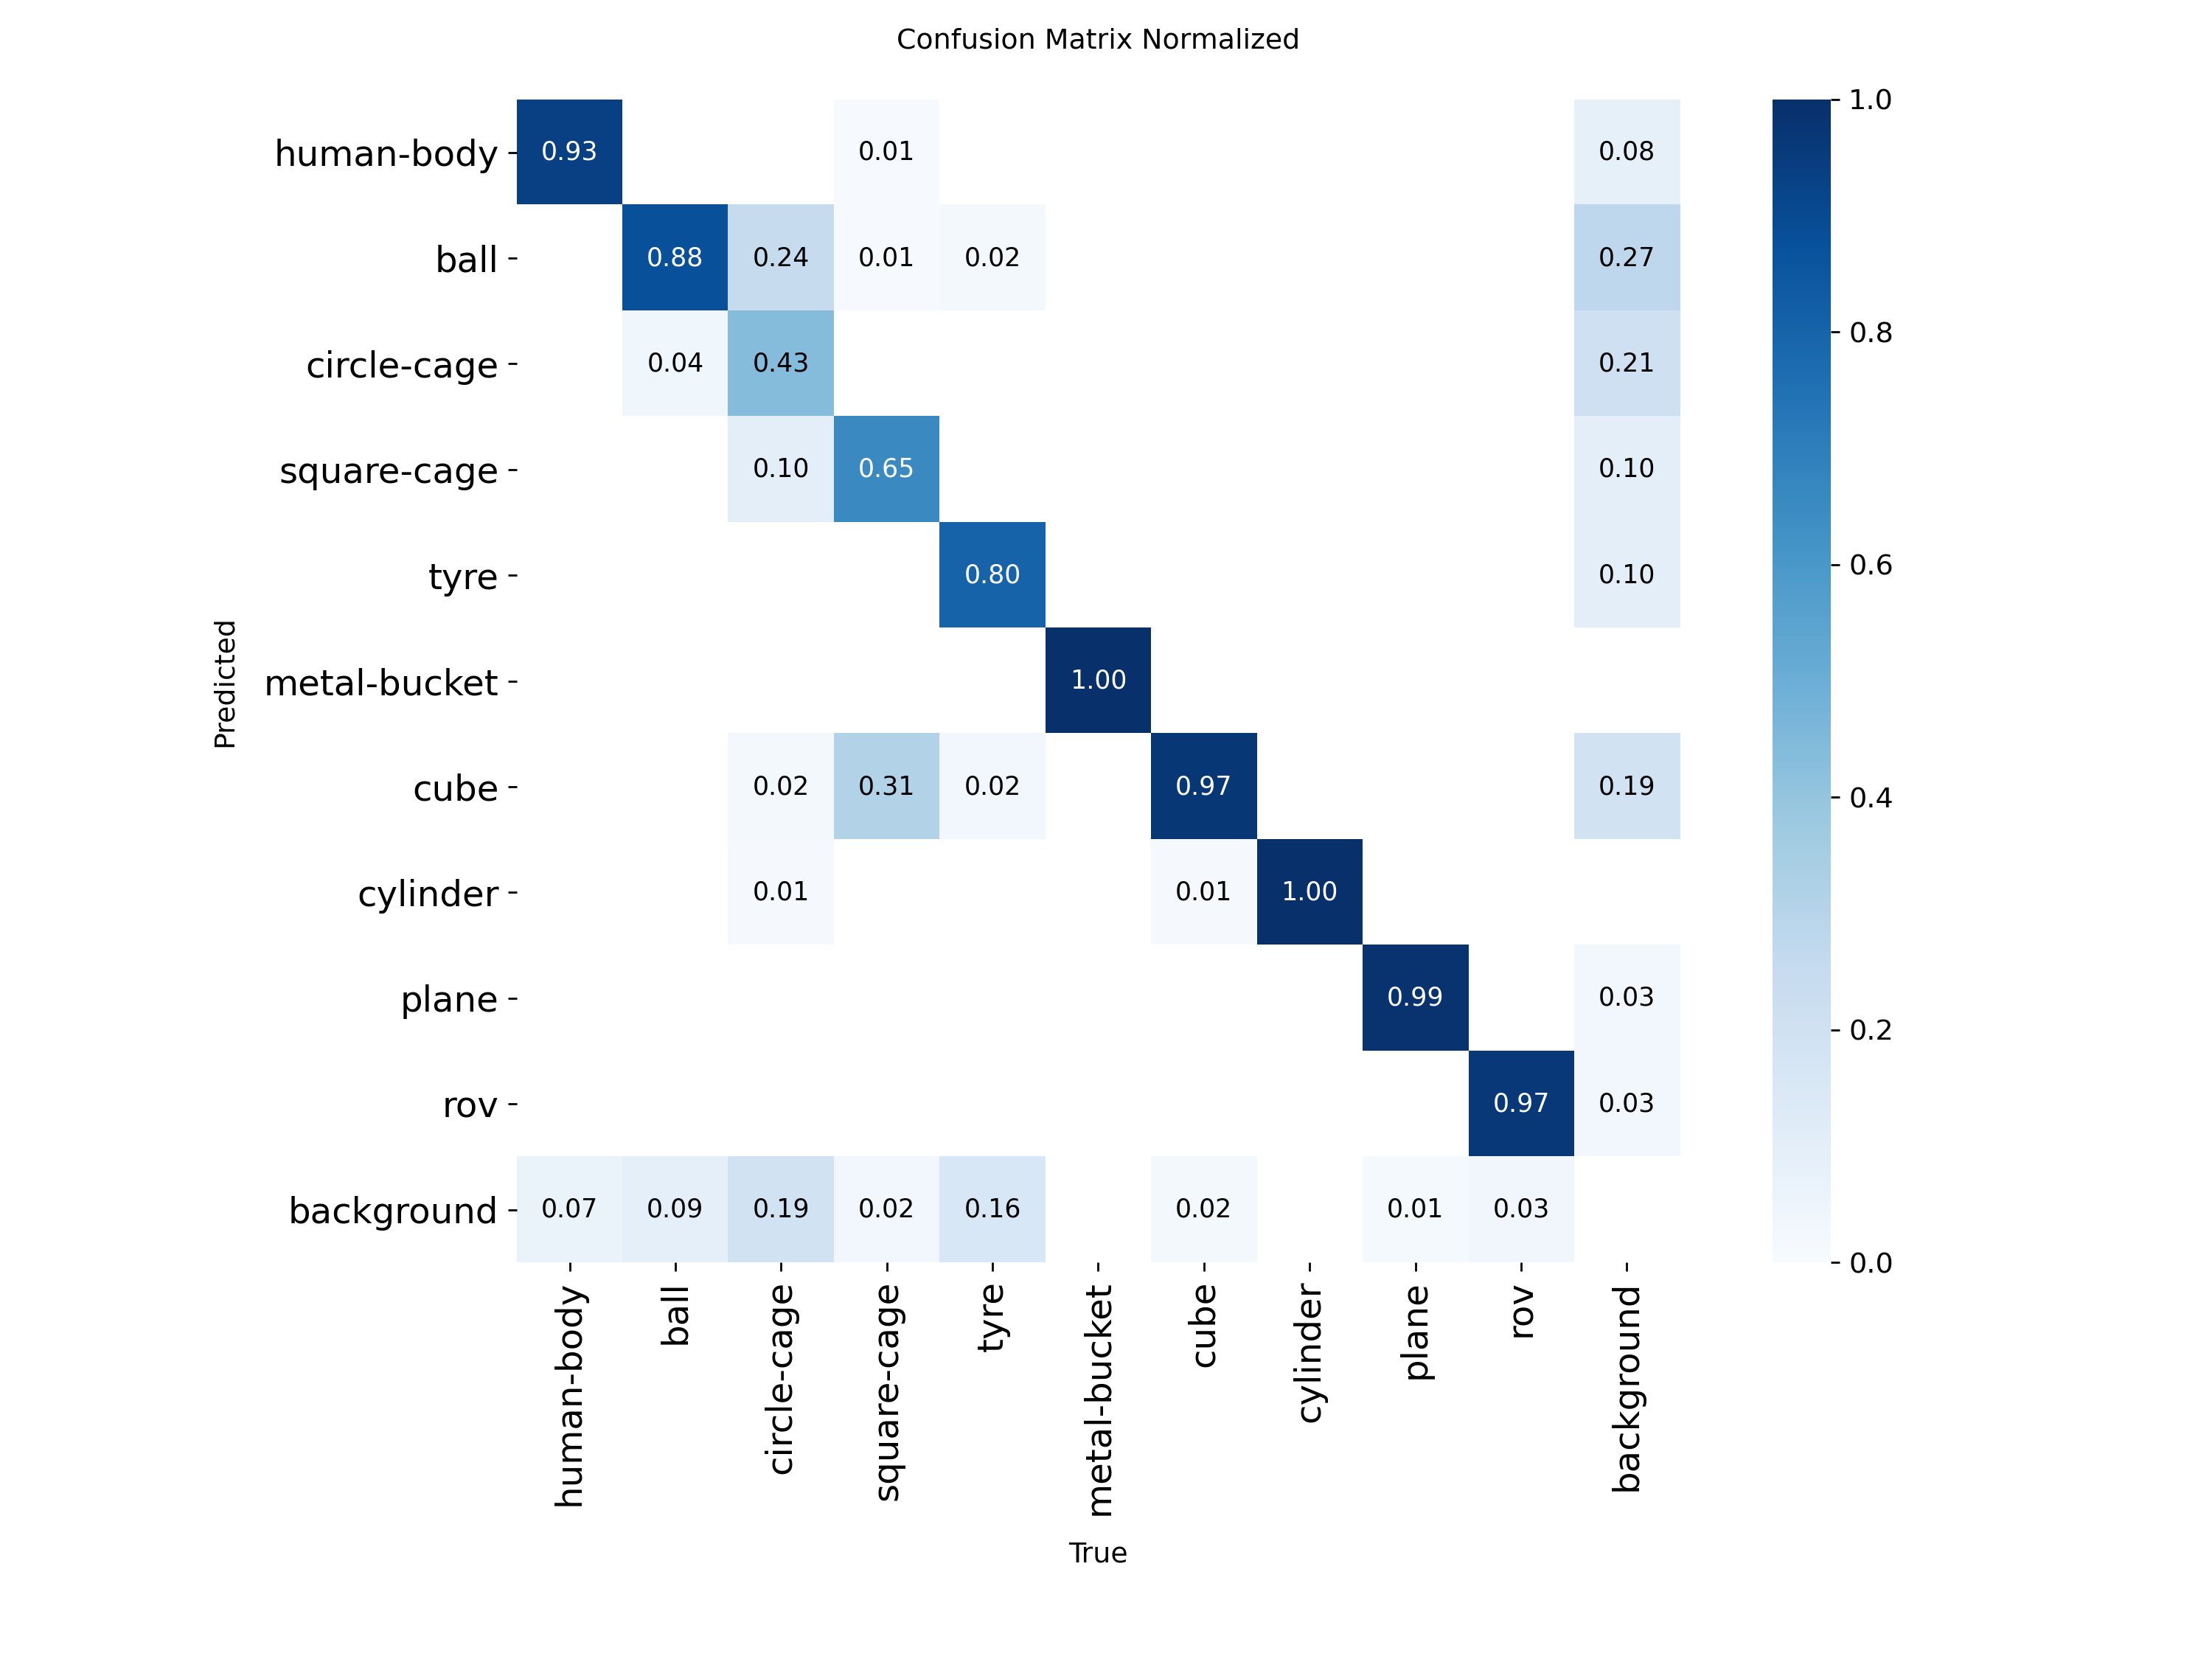

In [3]:
from IPython.display import display, Image, HTML
import os, glob

# 👉 change if you used a different name
run_dir = "runs_aquayolo/aquayolo_eval"

# 1) Curves + confusion matrices
to_show = [
    "BoxPR_curve.png",      # PR curve (per class)
    "BoxP_curve.png",       # Precision vs conf
    "BoxR_curve.png",       # Recall vs conf
    "BoxF1_curve.png",      # F1 vs conf
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
]
for f in to_show:
    p = os.path.join(run_dir, f)
    if os.path.exists(p):
        print("📈", f)
        display(Image(filename=p))
    else:
        print("⚠️ missing:", p)




## Show predictions


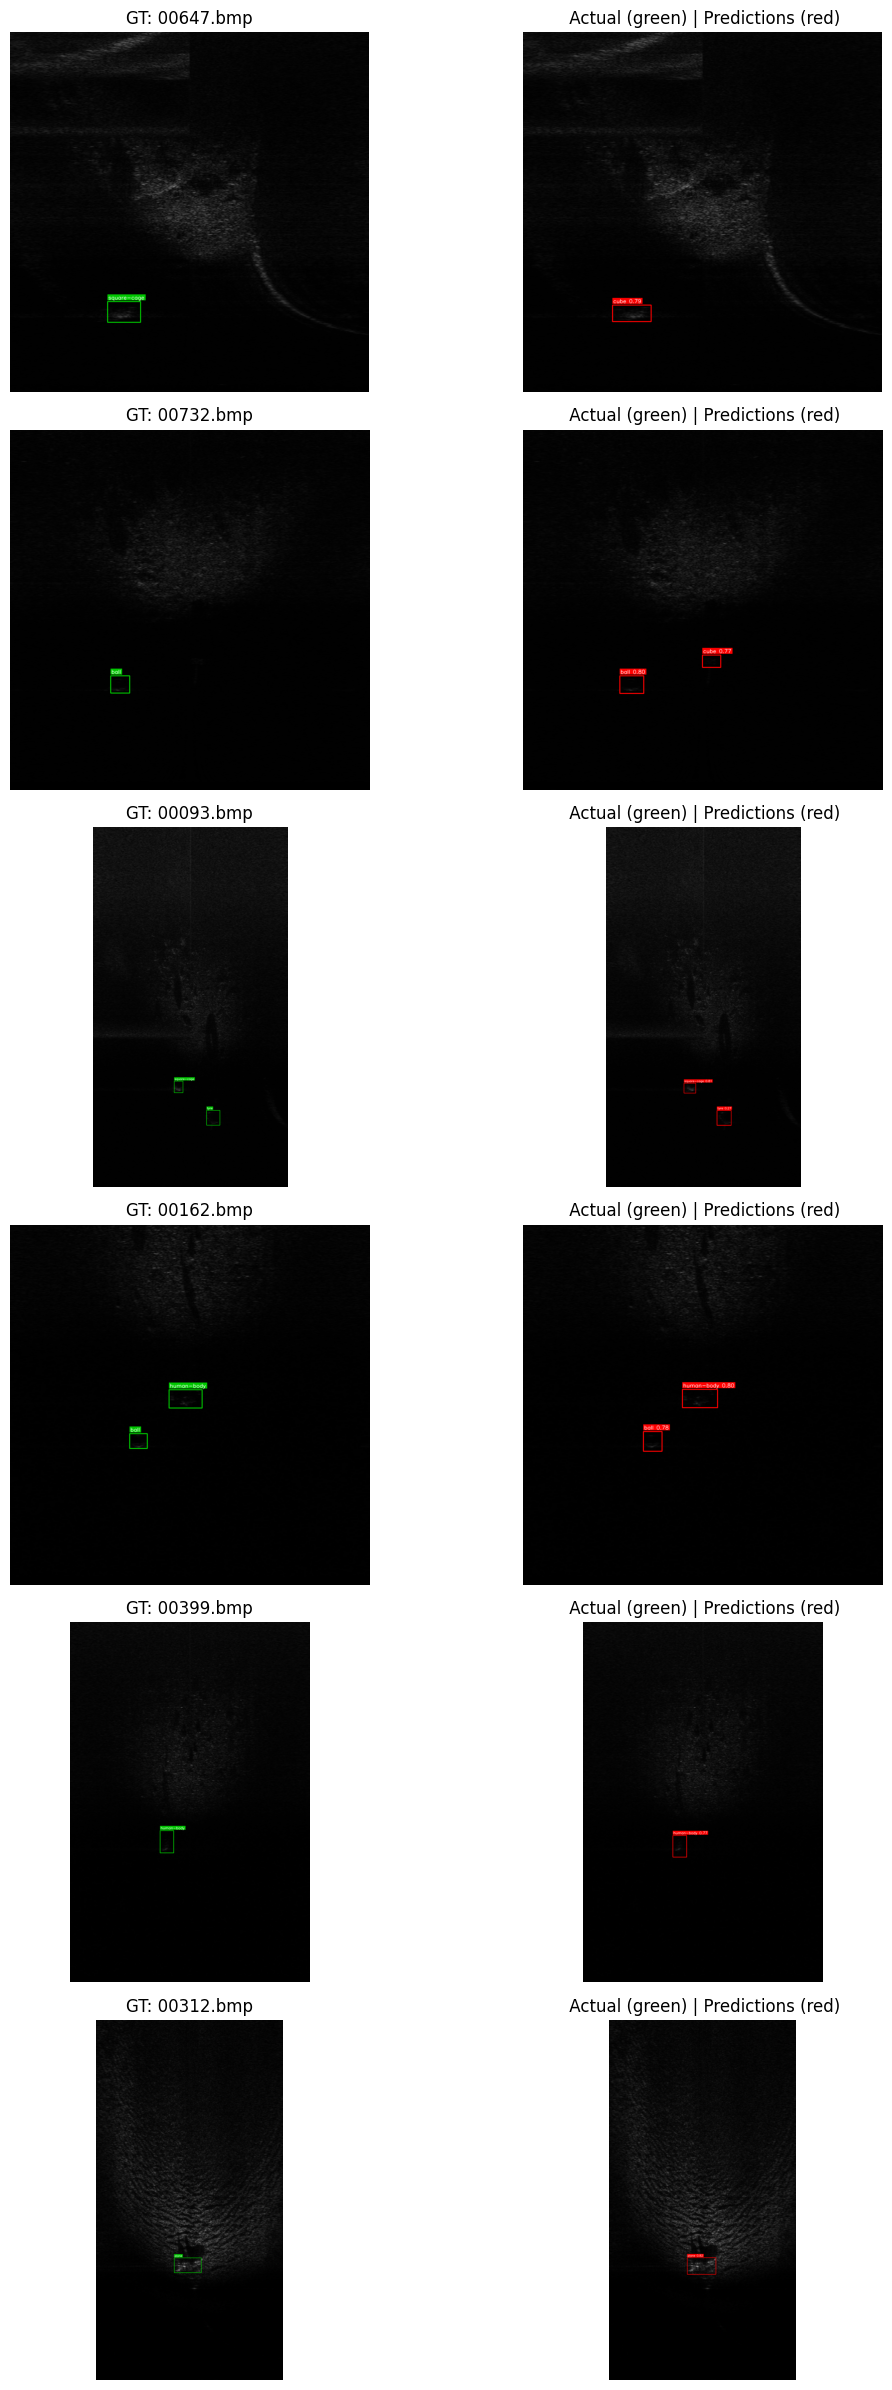

In [13]:



import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

%matplotlib inline


# ---- Config ----
data_root = Path("data/UATD")
images_dir = data_root / "images" / "test"   
labels_dir = data_root / "labels" / "test"
weights = "runs_aquayolo/aquayolo_m_SGD_640_4gpu_stable2/weights/best.pt"

num_samples = 6      # how many random examples to show
conf_thres = 0.25    # prediction confidence threshold
imgsz = 640          # inference size

# ---- Load model ----
model = YOLO(weights)
names = model.names

# ---- Helpers ----
def yolo_txt_to_xyxy(txt_line, img_w, img_h):
    """Convert 'cls cx cy w h' (normalized) to xyxy pixel coords."""
    c, cx, cy, w, h = txt_line.strip().split()
    c = int(float(c))
    cx, cy, w, h = map(float, (cx, cy, w, h))
    x1 = (cx - w/2) * img_w
    y1 = (cy - h/2) * img_h
    x2 = (cx + w/2) * img_w
    y2 = (cy + h/2) * img_h
    return c, int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

def draw_boxes(img, boxes, labels=None, color=(255, 0, 0), thickness=2):
    """Draw boxes [(x1,y1,x2,y2), ...] with optional label strings."""
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels is not None:
            txt = labels[i]
            (tw, th), bl = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            ytxt = max(0, y1 - 4)
            cv2.rectangle(img, (x1, ytxt - th - 4), (x1 + tw + 4, ytxt), color, -1)
            cv2.putText(img, txt, (x1 + 2, ytxt - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return img

# ---- Collect images ----
image_paths = sorted([p for p in images_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])
random.shuffle(image_paths)
image_paths = image_paths[:num_samples]

# ---- Inference + plot ----
cols = 2
rows = len(image_paths)
plt.figure(figsize=(12, 4 * rows))

for idx, img_path in enumerate(image_paths, 1):
    # Load image
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"⚠️ Could not read {img_path}")
        continue
    h, w = img_bgr.shape[:2]

    # --- Ground truth ---
    gt_boxes, gt_labels = [], []
    lbl_path = labels_dir / (img_path.stem + ".txt")
    if lbl_path.exists():
        with open(lbl_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                c, x1, y1, x2, y2 = yolo_txt_to_xyxy(line, w, h)
                gt_boxes.append((x1, y1, x2, y2))
                gt_labels.append(names.get(c, str(c)))
    gt_img = img_bgr.copy()
    gt_img = draw_boxes(gt_img, gt_boxes, gt_labels, color=(0, 200, 0), thickness=2)  # green for GT

    # --- Predictions ---
    # Run model; get per-image results
    res = model.predict(str(img_path), imgsz=imgsz, conf=conf_thres, verbose=False)[0]
    pred_boxes, pred_labels = [], []
    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy.cpu().numpy().astype(int)
        cls  = res.boxes.cls.cpu().numpy().astype(int)
        conf = res.boxes.conf.cpu().numpy()
        for (x1, y1, x2, y2), c, p in zip(xyxy, cls, conf):
            pred_boxes.append((x1, y1, x2, y2))
            pred_labels.append(f"{names.get(c, str(c))} {p:.2f}")
    pred_img = img_bgr.copy()
    pred_img = draw_boxes(pred_img, pred_boxes, pred_labels, color=(0, 0, 255), thickness=2)  # red for Pred

    # --- Matplotlib show (convert BGR->RGB) ---
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    pr_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, 2*(idx-1)+1)
    plt.imshow(gt_rgb)
    plt.title(f"GT: {img_path.name}")
    plt.axis("off")

    plt.subplot(rows, cols, 2*(idx-1)+2)
    plt.imshow(pr_rgb)
    plt.title(" Actual (green) | Predictions (red)")
    plt.axis("off")

plt.tight_layout()
plt.show()
